In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
import myd2l

In [ ]:
batch_size, num_steps = 32, 35
path = 'E:/Datasets/timemachine/timemachine.txt'
train_iter, vocab = myd2l.load_data_time_machine(batch_size=batch_size, n_steps=num_steps, path=path)

print(vocab.token_freqs[:10])
print(len(vocab))
print(F.one_hot(torch.tensor([0, 2]), len(vocab)))

[(' ', 29927), ('e', 17838), ('t', 13515), ('a', 11704), ('i', 10138), ('n', 9917), ('o', 9758), ('s', 8486), ('h', 8257), ('r', 7674)]
28
tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])


In [34]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01
    
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros((1, num_hiddens), device=device)
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros((1, num_outputs), device=device)

    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    
    return params

def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

def rnn(inputs, state, params):
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []

    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    
    return torch.cat(outputs, dim=0), (H, )

class RNNModelScratch:
    def __init__(self, vocab_size, num_hiddens, device, get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn
    
    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device) 

X = torch.arange(10).reshape((2, 5))
print(F.one_hot(X.T, len(vocab)).shape)

num_hiddens = 512
device = torch.device('cuda')
net = RNNModelScratch(len(vocab), num_hiddens, device, get_params, init_rnn_state, rnn)
state = net.begin_state(X.shape[0], device)
Y, new_state = net(X.to(device), state)

print(Y.shape, len(new_state), new_state[0].shape)

torch.Size([5, 2, 28])
torch.Size([10, 28]) 1 torch.Size([2, 512])


In [35]:
def predict(prefix, num_preds, net, vocab, device):
    state = net.begin_state(1, device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor(outputs[-1], device=device).reshape((1, 1))

    for y in prefix[1:]:
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    
    for _ in range(num_preds):
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    
    return ''.join([vocab.idx_to_token[i] for i in outputs])

predict('time traveller ', 10, net, vocab, device)

'time traveller qpnj<unk>kfxxn'

In [5]:
def grad_clipping(net, theta):
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.require_grad]
    else:
        params = net.params
    
    norm = torch.sqrt(sum(torch.sum(p.grad ** 2) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm


In [36]:
def train_epoch(net, train_iter, loss, updater, device, use_random_iter):
    state = None
    time_start = time.time()
    loss_sum = 0.0
    m = 0

    for X, Y in train_iter:
        if state is None or use_random_iter:
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                state.detach_()
            else:
                for s in state:
                    s.detach_()
        
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long())
        loss_sum += l.item()

        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            updater(batch_size=1)
        
        m += 1
    
    return math.exp(loss_sum / m), m * X.shape[0] * X.shape[1] / (time.time() - time_start) 
        
    

In [ ]:
def train(net ,train_iter, vocab, lr, num_epochs, device, use_random_iter=False):
    loss = nn.CrossEntropyLoss()

    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: myd2l.sgd(net.params, lr, batch_size)

    predict = lambda prefix: myd2l.predict(prefix, 50, net, vocab, device)

    ppls = []
    for epoch in range(num_epochs):
        ppl, speed = train_epoch(net, train_iter, loss, updater, device, use_random_iter)
        ppls.append(ppl)
    
        if (epoch + 1) % 10 == 0:
            print(f'epoch {epoch + 1: d}, perplexity {ppl: .1f}')
            print(predict('time traveller '))
    
    fig, ax = plt.subplots(figsize=(5, 2.5))
    ax.grid(True)
    ax.set_xlabel('epoch')
    ax.set_ylabel('perplexity')
    ax.plot(range(1, 1 + num_epochs), ppls)
    plt.show()

    print(f'perplexity {ppl: .1f}, speed {speed: .1f} examples/sec on {str(device)}')
    print(predict('time traveller '))
    print(predict('traveller '))
    

epoch  10, perplexity  13.7
time traveller the the the the the the the the the the the the th
epoch  20, perplexity  10.6
time traveller the the the the the the the the the the the the th
epoch  30, perplexity  9.6
time traveller and and and and and and and and and and and and an
epoch  40, perplexity  9.0
time traveller and the the the the the the the the the the the th
epoch  50, perplexity  8.5
time traveller and the the the the the the the the the the the th
epoch  60, perplexity  8.2
time traveller and and and and and and and and and and and and an
epoch  70, perplexity  8.2
time traveller and he the thimenston and he prace the thimens of 
epoch  80, perplexity  7.7
time traveller and the that simens of the that simens of the that
epoch  90, perplexity  7.5
time traveller and he the the the the the the the the the the the
epoch  100, perplexity  7.3
time traveller and the the the the the the the the the the the th
epoch  110, perplexity  7.0
time traveller and the the the the the 

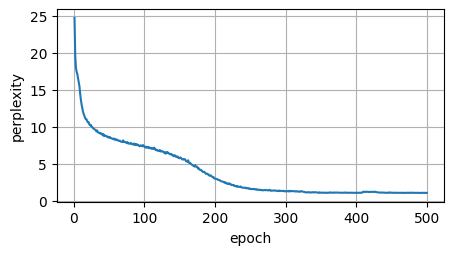

perplexity  1.0, speed  64352.7 examples/sec on cuda
time traveller for so it will be convenient to speak of himwas ex
traveller with a slight accession ofcheerfulness really this


In [38]:
num_epochs, lr = 500, 1
device = torch.device('cuda')
train(net, train_iter, vocab, lr, num_epochs, device)